In [1]:
import numpy as np 
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torchvision.datasets as datasets


Bad key "text.kerning_factor" on line 4 in
C:\Users\Rajit_Sanghvi\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
# let’s initialize the MNIST train and test set.
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
train_batch_size = 6000
test_batch_size = 1000

In [5]:
train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=train_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=test_batch_size, shuffle=False)

In [6]:
dataiter = iter(train_loader)
X_batch, y_batch = dataiter.next()

print(X_batch.shape)
print(y_batch.shape)

torch.Size([6000, 1, 28, 28])
torch.Size([6000])


tensor(5)


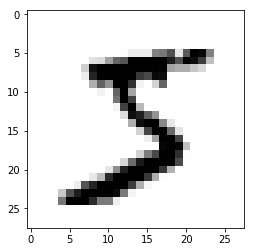

In [7]:
plt.imshow(X_batch[0].numpy().squeeze(), cmap='gray_r'); print(y_batch[0])

In [8]:
input_size = 784
hidden_layer = [250, 100]
output_size = 10

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_layer[0])
        self.linear2 = nn.Linear(hidden_layer[0], hidden_layer[1])
        self.linear3 = nn.Linear(hidden_layer[1], output_size)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = F.softmax(self.linear3(X), dim=1)
        return X
 
mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [11]:
def fit(model, train_loader):
           
    # Adam optimizer
    optimizer = torch.optim.Adam(model.parameters()) # lr=0.001, betas=(0.9,0.999))
    
    # cross entropy function
    error = nn.CrossEntropyLoss()
    
    EPOCHS = 20
        
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            
            # wrapping tensors in variables,  If x is a Variable then x.data is a Tensor giving its value, 
            # and x.grad is another Variable holding the gradient of x with respect to some scalar value
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            
            var_X_batch = torch.reshape(var_X_batch, (train_batch_size, 784))
                        
            # we need to set the gradients to zero before starting to do backpropragation
            optimizer.zero_grad()
            
            # output of the model
            output = model.forward(var_X_batch)
                        
            # Calculating the loss 
            loss = error(output, var_y_batch)
            
            # Let's do backpropogation, it will calculate all the gradients and save to x.grad
            loss.backward()
            
            # Performs a single optimization step,  
            #parameter update based on the current gradient (stored in .grad attribute of a parameter) and the update rule
            optimizer.step()
            
            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            
        
        print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
            epoch+1, 
            (batch_idx+1)*(len(X_batch)), 
            len(train_loader.dataset), 
            100.*(batch_idx+1) / len(train_loader), 
            loss.data, 
            float(correct*100) / float(train_batch_size*(batch_idx+1))))

In [12]:
fit(mlp, train_loader)

Epoch : 1 [60000/60000 (100%)]	Loss: 1.693004	 Accuracy:74.147%
Epoch : 2 [60000/60000 (100%)]	Loss: 1.685052	 Accuracy:76.448%
Epoch : 3 [60000/60000 (100%)]	Loss: 1.669223	 Accuracy:77.047%
Epoch : 4 [60000/60000 (100%)]	Loss: 1.617264	 Accuracy:81.402%
Epoch : 5 [60000/60000 (100%)]	Loss: 1.569887	 Accuracy:87.512%
Epoch : 6 [60000/60000 (100%)]	Loss: 1.551165	 Accuracy:89.763%
Epoch : 7 [60000/60000 (100%)]	Loss: 1.543229	 Accuracy:90.705%
Epoch : 8 [60000/60000 (100%)]	Loss: 1.537629	 Accuracy:91.303%
Epoch : 9 [60000/60000 (100%)]	Loss: 1.533817	 Accuracy:91.787%
Epoch : 10 [60000/60000 (100%)]	Loss: 1.530866	 Accuracy:92.085%
Epoch : 11 [60000/60000 (100%)]	Loss: 1.528270	 Accuracy:92.363%
Epoch : 12 [60000/60000 (100%)]	Loss: 1.525823	 Accuracy:92.657%
Epoch : 13 [60000/60000 (100%)]	Loss: 1.523532	 Accuracy:92.845%
Epoch : 14 [60000/60000 (100%)]	Loss: 1.521345	 Accuracy:93.102%
Epoch : 15 [60000/60000 (100%)]	Loss: 1.519344	 Accuracy:93.305%
Epoch : 16 [60000/60000 (100%)]	Lo

In [13]:
def evaluate(model):
#model = mlp
    correct = 0 
    for test_imgs, test_labels in test_loader:
        
        test_imgs = Variable(test_imgs).float()
        test_imgs = torch.reshape(test_imgs, (test_batch_size, 784))
        
        output = model(test_imgs)
        
        predicted = torch.max(output,1)[1]
        
        correct += (predicted == test_labels).sum()
        
    print("Test accuracy:{:.3f} % ".format( float(correct*100) / (len(test_loader)*test_batch_size)))
    
evaluate(mlp)

Test accuracy:93.640 % 
